In [1]:
import scanpy as sc
import pandas as pd
from sccoda.util import cell_composition_data as dat
from sccoda.util import comp_ana as mod
from sccoda.util import data_visualization as viz
import matplotlib.pyplot as plt
import numpy as np

2025-05-08 12:19:07.566052: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-08 12:19:07.567807: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-08 12:19:07.606680: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-08 12:19:07.607548: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-08 12:19:09.533438: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
#read in adata file from analysis.ipynb
adata = sc.read("refs/adata.h5ad")

/projectnb/bf528/students/npetruni/.conda/envs/sccoda_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [3]:
#create cell counts matrix
counts_df = (
    adata.obs
    .groupby(['sample', 'manual_labels'])
    .size()
    .unstack(fill_value=0)
)

# Optional: View summary
counts_df

manual_labels,Endothelial cells,Epithelial cells,Erythroids,Fibroblasts,ILC,Macrophages,Microglia,Monocytes,Plasma cells,T cells,Unknown
sample,,,,,,,,,,,
Case1_YF,123,6731,2,674,429,5788,0,0,1443,572,5798
Case1_ZY,2047,4741,1,512,69,1591,0,0,1032,3310,369
Case2_ZC,0,433,4509,1,2,0,828,39,794,0,0
Case2_YF,176,179,9,5261,3112,1299,18,0,255,1465,0
Case2_ZY,2752,474,1,2330,100,1847,1,0,202,1679,2
Case3_YF,3207,61,0,4117,565,85,0,0,484,769,3
Case3_ZY,2022,47,0,2671,866,731,0,0,383,1984,0
Case4_ZY,804,8,0,662,0,2,0,0,66,111,0


In [4]:
#create covariate df

covariates_df = pd.DataFrame({
    'sample': [
        'Case1_YF', 'Case1_ZY', 'Case2_ZC', 'Case2_YF',
        'Case2_ZY', 'Case3_YF', 'Case3_ZY', 'Case4_ZY'
    ],
    'tissue_type': [
        'PDAC', 'Metastasis', 'Normal', 'PDAC',
        'Metastasis', 'PDAC', 'Metastasis', 'Metastasis'
    ]
}).set_index('sample')

In [5]:
#reorders and filters the rows in counts_df to match exactly the sample order and list in covariates_df
counts_df = counts_df.loc[covariates_df.index]
#add pseudo count of 1 to prevent issues
counts_df += 1

In [6]:
#convert to scCODA object
counts_df = counts_df.merge(covariates_df, left_index=True, right_index=True)
data_all = dat.from_pandas(counts_df, covariate_columns=['tissue_type'])

print(data_all)

AnnData object with n_obs × n_vars = 8 × 11
    obs: 'tissue_type'


/projectnb/bf528/students/npetruni/.conda/envs/sccoda_env/lib/python3.8/site-packages/sccoda/util/data_visualization.py:335: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(cell_types, rotation=90)


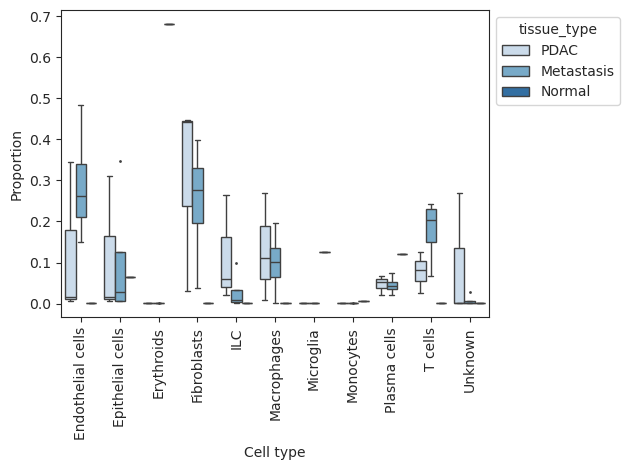

In [7]:
viz.boxplots(data_all, feature_name="tissue_type")
plt.show()

In [8]:
#run scCODA
model = mod.CompositionalAnalysis(data_all, formula="tissue_type", reference_cell_type="Fibroblasts")
sim_results = model.sample_hmc()

2025-05-08 12:19:38.836612: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x14c1c0009230 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-05-08 12:19:38.836663: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
  0%|          | 0/20000 [00:00<?, ?it/s]2025-05-08 12:19:38.885590: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-05-08 12:19:39.352290: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|██████████| 20000/20000 [02:33<00:00, 130.45it/s]


MCMC sampling finished. (194.383 sec)
Acceptance rate: 63.2%


In [9]:
#view results
summary_df = sim_results.summary()
summary_df

Compositional Analysis summary:

Data: 8 samples, 11 cell types
Reference index: 3
Formula: tissue_type

Intercepts:
                   Final Parameter  Expected Sample
Cell Type                                          
Endothelial cells            0.343      1992.435473
Epithelial cells            -0.562       806.023602
Erythroids                  -1.917       207.911607
Fibroblasts                  0.479      2282.697246
ILC                         -0.779       648.792553
Macrophages                 -0.309      1038.064318
Microglia                   -1.929       205.431578
Monocytes                   -1.925       206.254950
Plasma cells                -0.412       936.465822
T cells                      0.194      1716.620867
Unknown                     -1.546       301.301982


Effects:
                                         Final Parameter  Expected Sample  \
Covariate             Cell Type                                             
tissue_type[T.Normal] Endothelial cells   

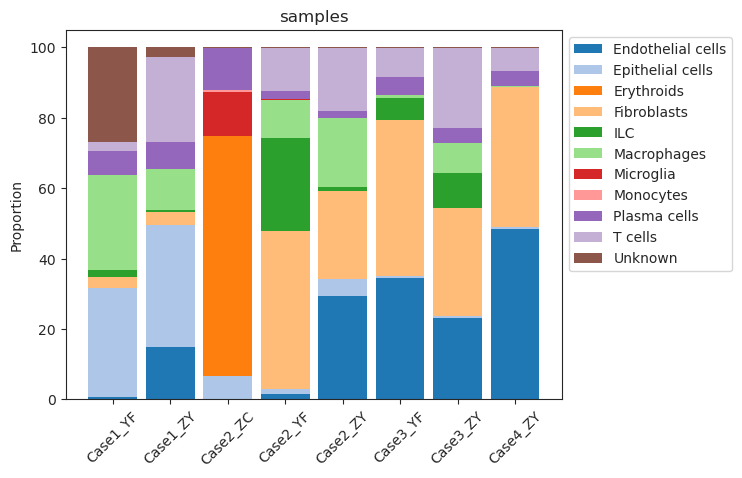

In [10]:
viz.stacked_barplot(data_all, feature_name="samples")
plt.show()

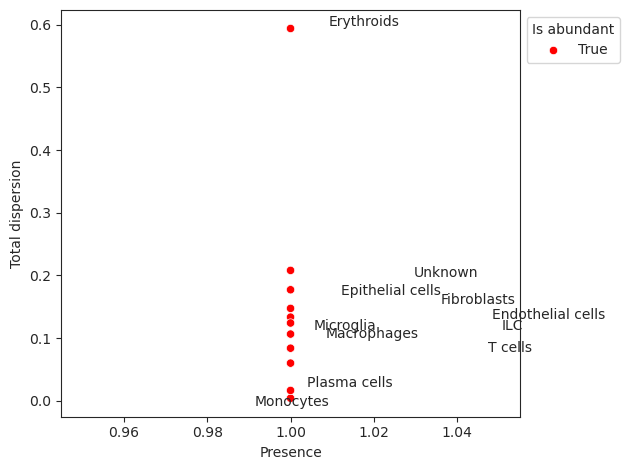

In [11]:
# Relative abundance vs dispersion
viz.rel_abundance_dispersion_plot(data=data_all, abundant_threshold=0.9)

# Jitter text labels
ax = plt.gca()
for text in ax.texts:
    x, y = text.get_position()
    text.set_position((x + np.random.uniform(-0.03, 0.03), y + np.random.uniform(-0.03, 0.03)))

plt.show()

## Discussion

As an additional analysis, I applied scCODA, a Bayesian compositional model, to identify shifts in cell type proportions across PDAC, metastatic, and normal tissues. By choosing fibroblasts as a stable reference cell type, I was able to model relative changes while accounting for the compositional nature of single-cell data. My results show a depletion of epithelial cells and erythroids in PDAC compared to normal tissue, and an expansion of endothelial cells and T cells in metastatic samples. These shifts are consistent with literature showing epithelial plasticity and immune infiltration during tumor progression (Dongre & Weinberg, 2019). This analysis highlights cell types that may play a role in tumor development and dissemination, offering targets for future mechanistic studies or therapeutic intervention.